# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/ICV_final" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/ICV_final


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

ROTATION_ANGLE = [0,90,180,270]

def rotate_img(img, rot):
    rot = ROTATION_ANGLE[rot]
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot in [90, 180, 270]:
        return transforms.functional.rotate(img,rot)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

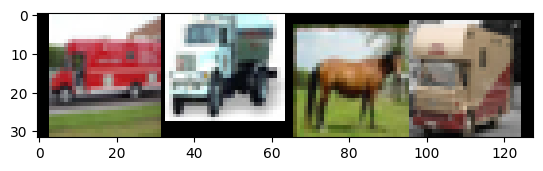

Class labels:  truck truck horse truck


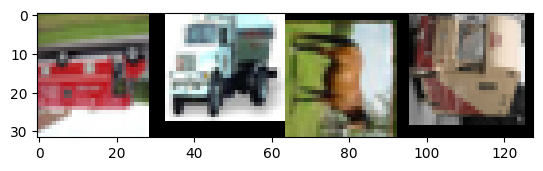

Rotation labels:  180   0     270   270  


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [6]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.max(outputs.data,1)[1]

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return avg_test_loss.item(), 100*correct/total

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim

# TODO: Define criterion and optimizer
optimizer = optim.Adam(params = net.parameters() ,lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    logger = {
        'train_loss' :[],
        'train_acc' :[],
        'test_loss' : [],
        'test_acc' : []
    }
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        train_logger = {'loss' : [], 'acc' : []}

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == "rotation":
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == "classification":
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.max(output.data,1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        logger['train_loss'].append(running_loss/print_freq)
        logger['train_acc'].append(100*running_correct/running_total)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        test_loss, test_acc = run_test(net, testloader, criterion, task)

    logger['test_loss'].append(test_loss)
    logger['test_acc'].append(test_acc)
    print('Finished Training')
    return logger

[1,   100] loss: 0.677 acc: 72.88 time: 4.60
[1,   200] loss: 0.694 acc: 72.59 time: 4.03
[1,   300] loss: 0.868 acc: 66.60 time: 4.20
TESTING:
Accuracy of the network on the 10000 test images: 58.95 %
Average loss on the 10000 test images: 1.063
[2,   100] loss: 0.969 acc: 60.62 time: 4.49
[2,   200] loss: 0.885 acc: 63.70 time: 4.22
[2,   300] loss: 0.842 acc: 65.27 time: 4.01
TESTING:
Accuracy of the network on the 10000 test images: 69.14 %
Average loss on the 10000 test images: 0.756
[3,   100] loss: 0.793 acc: 67.95 time: 4.25
[3,   200] loss: 0.778 acc: 68.48 time: 4.28
[3,   300] loss: 0.749 acc: 70.12 time: 4.05
TESTING:
Accuracy of the network on the 10000 test images: 70.04 %
Average loss on the 10000 test images: 0.738
[4,   100] loss: 0.733 acc: 70.70 time: 4.44
[4,   200] loss: 0.736 acc: 70.54 time: 4.15
[4,   300] loss: 0.729 acc: 71.09 time: 4.29
TESTING:
Accuracy of the network on the 10000 test images: 72.75 %
Average loss on the 10000 test images: 0.688
[5,   100] l

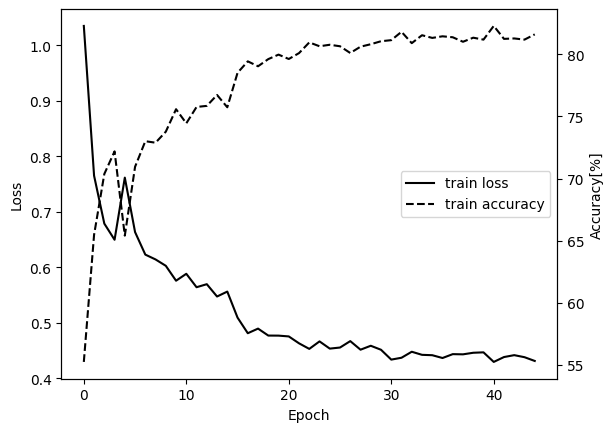

In [13]:
logger = train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

fig, ax1 = plt.subplots()

line1 = ax1.plot(range(45),logger['train_loss'],label = "train loss",color = 'k',ls = '-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
line2 = ax2.plot(range(45),logger['train_acc'],label = "train accuracy",color = 'k', ls = '--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy[%]')

lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

print("Test Loss : ", logger['test_loss'])
print("Test Accuracy : ", logger['test_acc'])

# TODO: Save the model
torch.save(net.state_dict(),"./model")

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

In [14]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
pretrained_dict = torch.load('./model') # Load your pretrained weights

In [15]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

# Freeze the previous layers
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Load the pretrained model
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

# Update the current model
net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [17]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr = 1e-3)

[1,   100] loss: 1.108 acc: 60.00 time: 4.55
[1,   200] loss: 1.108 acc: 60.27 time: 4.10
[1,   300] loss: 1.113 acc: 59.02 time: 4.22
TESTING:
Accuracy of the network on the 10000 test images: 62.30 %
Average loss on the 10000 test images: 1.070
[2,   100] loss: 1.107 acc: 59.84 time: 4.39
[2,   200] loss: 1.103 acc: 60.13 time: 4.13
[2,   300] loss: 1.104 acc: 60.30 time: 3.97
TESTING:
Accuracy of the network on the 10000 test images: 61.97 %
Average loss on the 10000 test images: 1.076
[3,   100] loss: 1.085 acc: 61.03 time: 4.14
[3,   200] loss: 1.091 acc: 60.45 time: 4.06
[3,   300] loss: 1.108 acc: 59.37 time: 4.28
TESTING:
Accuracy of the network on the 10000 test images: 62.19 %
Average loss on the 10000 test images: 1.063
[4,   100] loss: 1.105 acc: 60.31 time: 4.41
[4,   200] loss: 1.084 acc: 60.55 time: 4.05
[4,   300] loss: 1.085 acc: 60.97 time: 4.03
TESTING:
Accuracy of the network on the 10000 test images: 62.18 %
Average loss on the 10000 test images: 1.060
[5,   100] l

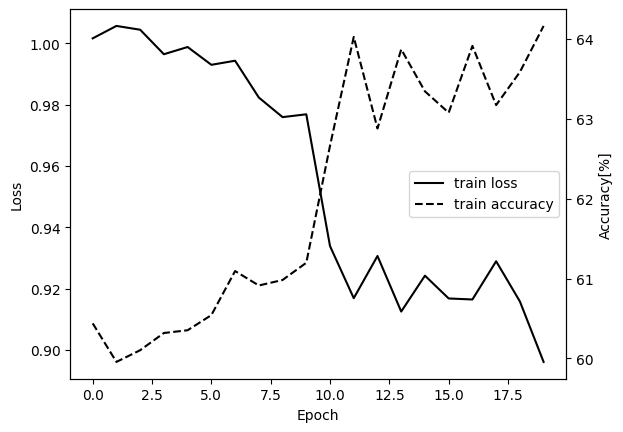

In [19]:
logger = train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

fig, ax1 = plt.subplots()

line1 = ax1.plot(range(20),logger['train_loss'],label = "train loss",color = 'k',ls = '-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
line2 = ax2.plot(range(20),logger['train_acc'],label = "train accuracy",color = 'k', ls = '--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy[%]')

lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

print("Test Loss : ", logger['test_loss'])
print("Test Accuracy : ", logger['test_acc'])

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

In [21]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
# Freeze the previous layers
pretrained_dict = net.state_dict()

for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Load the pretrained model
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

# Update the current model
net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)

In [22]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [23]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr = 1e-3, weight_decay = 5e-4)

[1,   100] loss: 2.265 acc: 23.97 time: 4.47
[1,   200] loss: 1.958 acc: 28.88 time: 4.04
[1,   300] loss: 1.910 acc: 30.74 time: 4.05
TESTING:
Accuracy of the network on the 10000 test images: 32.31 %
Average loss on the 10000 test images: 1.850
[2,   100] loss: 1.894 acc: 30.87 time: 4.19
[2,   200] loss: 1.888 acc: 31.34 time: 4.31
[2,   300] loss: 1.903 acc: 30.52 time: 4.03
TESTING:
Accuracy of the network on the 10000 test images: 34.71 %
Average loss on the 10000 test images: 1.812
[3,   100] loss: 1.884 acc: 31.01 time: 4.32
[3,   200] loss: 1.866 acc: 32.41 time: 4.11
[3,   300] loss: 1.878 acc: 30.91 time: 4.04
TESTING:
Accuracy of the network on the 10000 test images: 32.48 %
Average loss on the 10000 test images: 1.818
[4,   100] loss: 1.865 acc: 31.67 time: 4.19
[4,   200] loss: 1.854 acc: 32.52 time: 4.34
[4,   300] loss: 1.859 acc: 32.73 time: 4.17
TESTING:
Accuracy of the network on the 10000 test images: 34.45 %
Average loss on the 10000 test images: 1.789
[5,   100] l

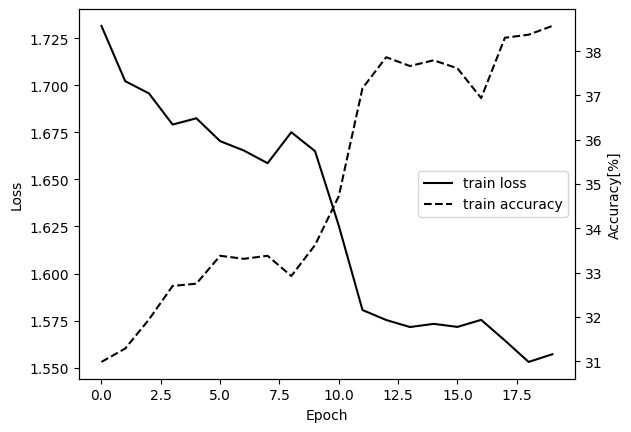

In [24]:
logger = train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

fig, ax1 = plt.subplots()

line1 = ax1.plot(range(20),logger['train_loss'],label = "train loss",color = 'k',ls = '-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
line2 = ax2.plot(range(20),logger['train_acc'],label = "train accuracy",color = 'k', ls = '--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy[%]')

lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

print("Test Loss : ", logger['test_loss'])
print("Test Accuracy : ", logger['test_acc'])


##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
pretrained_model = resnet18(pretrained=False) # set to False if you don't want to download pretrained weights on ImageNet
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

pretrained_dict = torch.load('./model') # Load your pretrained weights
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)


In [29]:
# TODO: Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

[1,   100] loss: 1.519 acc: 43.98 time: 4.30
[1,   200] loss: 1.125 acc: 59.84 time: 4.23
[1,   300] loss: 1.028 acc: 63.78 time: 4.01
TESTING:
Accuracy of the network on the 10000 test images: 69.49 %
Average loss on the 10000 test images: 0.886
[2,   100] loss: 0.913 acc: 67.90 time: 4.53
[2,   200] loss: 0.892 acc: 68.98 time: 4.18
[2,   300] loss: 0.848 acc: 70.19 time: 4.20
TESTING:
Accuracy of the network on the 10000 test images: 72.44 %
Average loss on the 10000 test images: 0.804
[3,   100] loss: 0.766 acc: 73.15 time: 4.39
[3,   200] loss: 0.789 acc: 72.18 time: 4.38
[3,   300] loss: 0.775 acc: 73.27 time: 4.14
TESTING:
Accuracy of the network on the 10000 test images: 75.89 %
Average loss on the 10000 test images: 0.701
[4,   100] loss: 0.728 acc: 74.94 time: 4.34
[4,   200] loss: 0.708 acc: 75.40 time: 4.16
[4,   300] loss: 0.717 acc: 74.91 time: 4.32
TESTING:
Accuracy of the network on the 10000 test images: 77.80 %
Average loss on the 10000 test images: 0.647
[5,   100] l

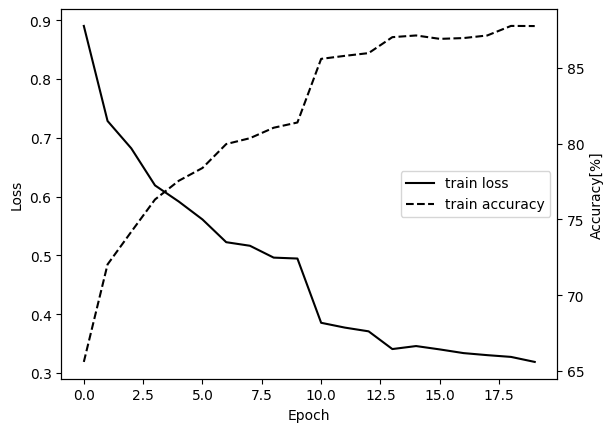

In [30]:
logger = train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

fig, ax1 = plt.subplots()

line1 = ax1.plot(range(20),logger['train_loss'],label = "train loss",color = 'k',ls = '-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
line2 = ax2.plot(range(20),logger['train_acc'],label = "train accuracy",color = 'k', ls = '--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy[%]')

lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

print("Test Loss : ", logger['test_loss'])
print("Test Accuracy : ", logger['test_acc'])

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [32]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10
net = net.to(device)

In [33]:
# TODO: Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

[1,   100] loss: 2.295 acc: 21.30 time: 4.43
[1,   200] loss: 1.894 acc: 31.87 time: 4.32
[1,   300] loss: 1.733 acc: 36.54 time: 4.23
TESTING:
Accuracy of the network on the 10000 test images: 43.30 %
Average loss on the 10000 test images: 1.589
[2,   100] loss: 1.537 acc: 44.15 time: 4.27
[2,   200] loss: 1.447 acc: 47.60 time: 4.28
[2,   300] loss: 1.375 acc: 50.34 time: 4.44
TESTING:
Accuracy of the network on the 10000 test images: 54.29 %
Average loss on the 10000 test images: 1.307
[3,   100] loss: 1.248 acc: 54.74 time: 4.39
[3,   200] loss: 1.212 acc: 56.55 time: 4.08
[3,   300] loss: 1.143 acc: 59.16 time: 4.46
TESTING:
Accuracy of the network on the 10000 test images: 59.93 %
Average loss on the 10000 test images: 1.140
[4,   100] loss: 1.092 acc: 61.37 time: 4.59
[4,   200] loss: 1.064 acc: 61.85 time: 4.12
[4,   300] loss: 1.018 acc: 64.14 time: 4.31
TESTING:
Accuracy of the network on the 10000 test images: 64.34 %
Average loss on the 10000 test images: 1.028
[5,   100] l

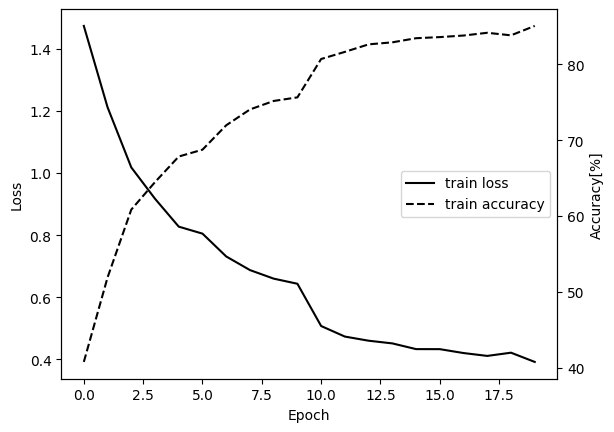

In [34]:
logger = train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

fig, ax1 = plt.subplots()

line1 = ax1.plot(range(20),logger['train_loss'],label = "train loss",color = 'k',ls = '-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
line2 = ax2.plot(range(20),logger['train_acc'],label = "train accuracy",color = 'k', ls = '--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy[%]')

lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

print("Test Loss : ", logger['test_loss'])
print("Test Accuracy : ", logger['test_acc'])

Extra Credits
=======

In [ ]:
from torch.utils.data import DataLoader, Dataset, Subset

def get_indices_per_category(dataset, num_examples_per_category):
    """Get indices for the specified number of examples per category."""
    class_indices = {i: [] for i in range(10)}  # CIFAR-10 has 10 classes

    for idx, (_, _, _ , label) in enumerate(dataset, 0):
        class_indices[label.item()].append(idx)

    sampled_indices = []
    for class_id, indices in class_indices.items():
        if num_examples_per_category > len(indices):
            raise ValueError(f"Not enough examples in class {class_id} to sample {num_examples_per_category} examples.")
        sampled_indices.extend(random.sample(indices, num_examples_per_category))

    return sampled_indices

def create_dataloaders(dataset, examples_per_category_list, batch_size=32):
    dataloaders = {}

    for num_examples in examples_per_category_list:
        indices = get_indices_per_category(dataset, num_examples)
        subset = Subset(dataset, indices)
        dataloaders[num_examples] = DataLoader(subset, batch_size=batch_size, shuffle=True)

    return dataloaders

N_lst = [20,100,400,1000,5000]
dataloaders = create_dataloaders(trainset, N_lst)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


TESTING:
Accuracy of the network on the 10000 test images: 23.42 %
Average loss on the 10000 test images: 2.175
TESTING:
Accuracy of the network on the 10000 test images: 35.93 %
Average loss on the 10000 test images: 2.130
TESTING:
Accuracy of the network on the 10000 test images: 37.47 %
Average loss on the 10000 test images: 1.711
TESTING:
Accuracy of the network on the 10000 test images: 42.93 %
Average loss on the 10000 test images: 1.592
TESTING:
Accuracy of the network on the 10000 test images: 56.21 %
Average loss on the 10000 test images: 1.241
TESTING:
Accuracy of the network on the 10000 test images: 49.57 %
Average loss on the 10000 test images: 1.403
TESTING:
Accuracy of the network on the 10000 test images: 69.69 %
Average loss on the 10000 test images: 0.908
TESTING:
Accuracy of the network on the 10000 test images: 52.68 %
Average loss on the 10000 test images: 1.309
TESTING:
Accuracy of the network on the 10000 test images: 80.68 %
Average loss on the 10000 test images

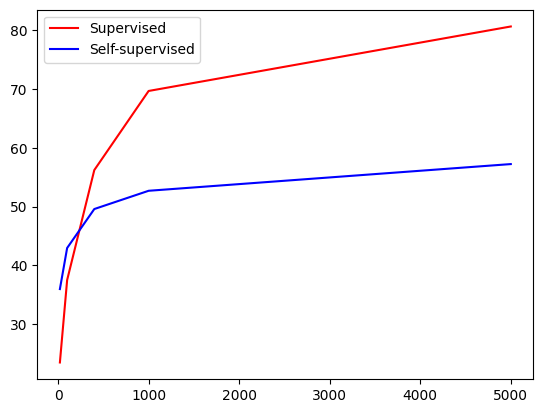

In [ ]:
logger = {'supervised' : [], 'self-supervised' : []}

for N in N_lst:
  sampled_examples = dataloaders[N]
  model_supervised = resnet18(pretrained=False)
  model_supervised.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10
  model_supervised = model_supervised.to(device)

  pretrained_dict = torch.load('./model') # Load your pretrained weights
  model_self_supervised = resnet18(pretrained=False)
  model_self_supervised.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

  for name, param in model_self_supervised.named_parameters():
      if 'layer4' not in name and 'fc' not in name:
          param.requires_grad = False

  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_self_supervised.state_dict() and model_self_supervised.state_dict()[k].shape == pretrained_dict[k].shape}
  model_self_supervised.load_state_dict(pretrained_dict, strict=False)
  model_self_supervised = model_self_supervised.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer1 = optim.Adam(params = model_supervised.parameters(), lr = 0.01)
  optimizer2 = optim.Adam(params = model_self_supervised.parameters(), lr = 0.01)

  scheduler1 = optim.lr_scheduler.LambdaLR(optimizer=optimizer1,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  scheduler2 = optim.lr_scheduler.LambdaLR(optimizer=optimizer2,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  for epochs in range(30):
    for imgs,_ ,_ , labels in sampled_examples:
      imgs, labels = imgs.to(device), labels.to(device)

      assert imgs.is_cuda and labels.is_cuda, "Tensors should be on GPU"

      optimizer1.zero_grad()
      output_supervised = model_supervised(imgs)
      loss_supervised = criterion(output_supervised, labels)
      loss_supervised.backward()
      optimizer1.step()

      optimizer2.zero_grad()
      output_self_supervised = model_self_supervised(imgs)
      loss_self_supervised = criterion(output_self_supervised, labels)
      loss_self_supervised.backward()
      optimizer2.step()

  scheduler1.step()
  scheduler2.step()

  _, supervised_acc = run_test(model_supervised, testloader, criterion, "classification")
  _, self_supervised_acc = run_test(model_self_supervised, testloader, criterion, "classification")

  logger['supervised'].append(supervised_acc)
  logger['self-supervised'].append(self_supervised_acc)

plt.plot(N_lst, logger['supervised'],color = 'r',label = "Supervised")
plt.plot(N_lst, logger['self-supervised'],color = 'b',label = "Self-supervised")
plt.legend()


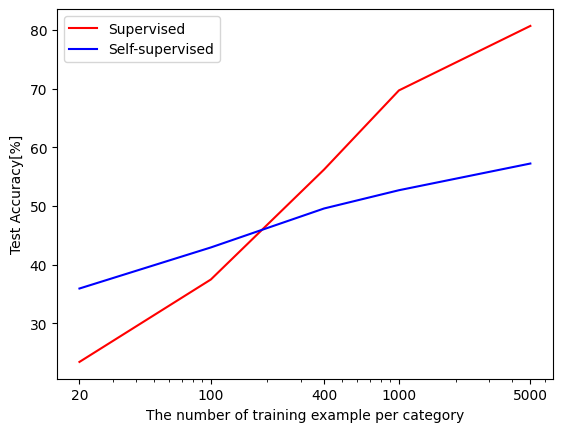

In [ ]:
plt.semilogx(N_lst, logger['supervised'],color = 'r',label = "Supervised")
plt.semilogx(N_lst, logger['self-supervised'],color = 'b',label = "Self-supervised")
plt.xticks([20, 100, 400, 1000, 5000],labels = ['20', '100', '400', '1000', '5000'])
plt.ylabel("Test Accuracy[%]")
plt.xlabel("The number of training example per category")
plt.legend()

In [ ]:
N

[20, 100, 400, 1000, 5000]